<a href="https://colab.research.google.com/github/cmccomb/TrussMe/blob/main/examples/optimizing_for_mass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install TrussMe

In [1]:
!pip install git+https://github.com/cmccomb/trussme.git -qqq

  Preparing metadata (setup.py) ... done


# Set up functions for optimization

In [2]:
import trussme
import scipy.optimize
import numpy

This is a helper function that support the translation between a vector of optimization parameters and the truss itself. We are enforcing symmetry and only optimizing the location of movable joints.

In [3]:
def make_truss(x: list[float]) -> trussme.Truss:
        # Build truss from scratch
        truss_from_commands = trussme.Truss()
        truss_from_commands.add_pinned_joint([-2.5, 0.0, 0.0])
        truss_from_commands.add_free_joint([x[0], x[1], 0.0])
        truss_from_commands.add_free_joint([x[2], x[3], 0.0])
        truss_from_commands.add_free_joint([-x[2], x[3], 0.0])
        truss_from_commands.add_free_joint([-x[0], x[1], 0.0])
        truss_from_commands.add_pinned_joint([2.5, 0.0, 0.0])

        truss_from_commands.add_free_joint([x[4], x[5], 0.0])
        truss_from_commands.add_free_joint([x[6], x[7], 0.0])
        truss_from_commands.add_free_joint([0.0, 1.0, 0.0])
        truss_from_commands.add_free_joint([-x[6], x[7], 0.0])
        truss_from_commands.add_free_joint([-x[4], x[5], 0.0])

        truss_from_commands.add_out_of_plane_support("z")

        truss_from_commands.joints[8].loads[1] = -50000

        truss_from_commands.add_member(0, 1)
        truss_from_commands.add_member(1, 2)
        truss_from_commands.add_member(2, 3)
        truss_from_commands.add_member(3, 4)
        truss_from_commands.add_member(4, 5)

        truss_from_commands.add_member(6, 7)
        truss_from_commands.add_member(7, 8)
        truss_from_commands.add_member(8, 9)
        truss_from_commands.add_member(9, 10)

        truss_from_commands.add_member(0, 6)
        truss_from_commands.add_member(6, 1)
        truss_from_commands.add_member(1, 7)
        truss_from_commands.add_member(7, 2)
        truss_from_commands.add_member(2, 8)
        truss_from_commands.add_member(8, 3)
        truss_from_commands.add_member(3, 9)
        truss_from_commands.add_member(9, 4)
        truss_from_commands.add_member(4, 10)
        truss_from_commands.add_member(10, 5)

        return truss_from_commands

Next, we create an objective for mass, two helper functions for constraints (FOS, deflection in cm) and a callback.

In [4]:
def mass_objective(x: list[float]) -> float:
    return make_truss(x).mass

In [5]:
def fos_constraint(x: list[float]) -> float:
    truss = make_truss(x)
    truss.analyze()
    return truss.fos

In [6]:
def deflection_constraint(x: list[float]) -> float:
    truss = make_truss(x)
    truss.analyze()
    return truss.deflection*100

In [7]:
def callback(intermediate_result: scipy.optimize.OptimizeResult):
    truss = make_truss(intermediate_result.x)
    truss.analyze()
    print(
        "mass = {:.2f} kg; ".format(truss.mass),
        "FOS = {:.2f} kg; ".format(truss.fos),
        "deflection = {:.2f} cm; ".format(truss.deflection*100)
    )

# Examine an intial truss design

In [8]:
x0 = [-1.5, 0.0, -0.5, 0.0, -2.0, 1.0, -1.0, 1.0]

mass = 37.58 kg;  FOS = 1.19;  deflection = 0.70 cm; 


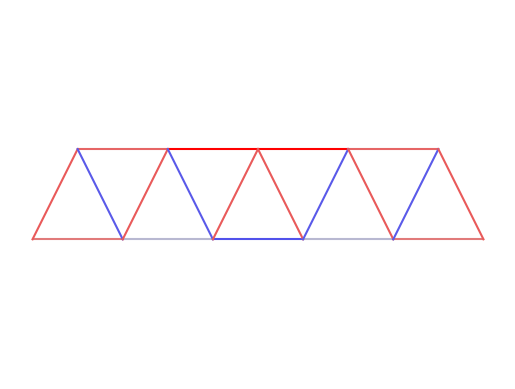

In [9]:
initial_truss = make_truss(x0)
initial_truss.analyze()
print(
    "mass = {:.2f} kg; ".format(initial_truss.mass),
    "FOS = {:.2f}; ".format(initial_truss.fos),
    "deflection = {:.2f} cm; ".format(initial_truss.deflection*100)
)
trussme.visualize.plot_truss(initial_truss, starting_shape="force");

# Optimize the truss and examine results

We'll make two more specific constraints using our earlier helper functions. Specifically, we'll constraint the FOS to be greater than 1.0, and the deflection to be less than 1.0cm.

In [10]:
fos_greater_than_1 = scipy.optimize.NonlinearConstraint(fos_constraint, 1.0, numpy.inf)
deflection_less_than_1cm = scipy.optimize.NonlinearConstraint(deflection_constraint, 0.0, 1.0)

In [11]:
result = scipy.optimize.minimize(
    mass_objective,
    x0,
    method='trust-constr',
    constraints=[
        fos_greater_than_1,
        deflection_less_than_1cm
    ],
    callback=callback,
    options={"maxiter": 50},

)

mass = 37.58 kg;  FOS = 1.19 kg;  deflection = 0.70 cm; 
mass = 33.10 kg;  FOS = 1.42 kg;  deflection = 0.57 cm; 
mass = 29.81 kg;  FOS = 1.26 kg;  deflection = 0.54 cm; 
mass = 29.81 kg;  FOS = 1.26 kg;  deflection = 0.54 cm; 
mass = 26.60 kg;  FOS = 0.63 kg;  deflection = 2.15 cm; 
mass = 26.22 kg;  FOS = 1.47 kg;  deflection = 0.53 cm; 
mass = 26.22 kg;  FOS = 1.47 kg;  deflection = 0.53 cm; 
mass = 25.82 kg;  FOS = 1.11 kg;  deflection = 0.54 cm; 
mass = 25.82 kg;  FOS = 1.11 kg;  deflection = 0.54 cm; 
mass = 25.62 kg;  FOS = 1.16 kg;  deflection = 0.72 cm; 
mass = 25.16 kg;  FOS = 1.26 kg;  deflection = 0.54 cm; 
mass = 25.16 kg;  FOS = 1.26 kg;  deflection = 0.54 cm; 
mass = 24.74 kg;  FOS = 0.88 kg;  deflection = 0.59 cm; 
mass = 24.74 kg;  FOS = 0.88 kg;  deflection = 0.59 cm; 
mass = 24.74 kg;  FOS = 0.88 kg;  deflection = 0.59 cm; 
mass = 24.68 kg;  FOS = 1.19 kg;  deflection = 0.57 cm; 
mass = 24.68 kg;  FOS = 1.19 kg;  deflection = 0.57 cm; 
mass = 24.68 kg;  FOS = 1.19 kg

mass = 24.61 kg;  FOS = 1.17 kg;  deflection = 0.50 cm; 


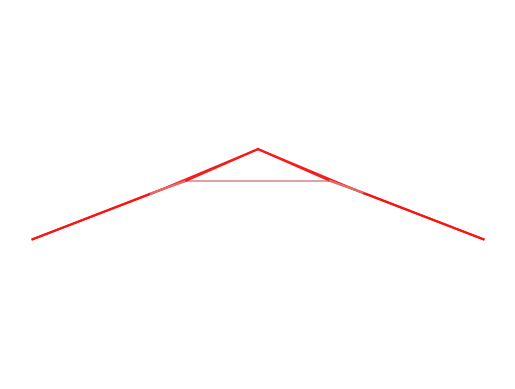

In [12]:
final_truss = make_truss(result.x)
final_truss.analyze()
callback(result)
trussme.visualize.plot_truss(final_truss, starting_shape="force");

In [13]:
final_truss.fos_buckling

1.1665746158046306